In [1]:
import numpy as np
import pandas as pd
import FinanceDataReader as fdr
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
from sklearn.metrics.pairwise import linear_kernel

In [2]:
# matplotlib rebuild

import matplotlib.pyplot as plt
from matplotlib import font_manager
%matplotlib inline


font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()

plt.rcParams["font.family"] = font_family
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["axes.formatter.limits"] = -10000, 10000


In [3]:
df = pd.read_csv('./data/preprocessing/preprocessed/df_tokenized.csv',index_col=0)

#### 사업보고서 fillings_month 체크

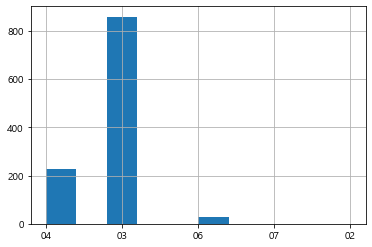

In [4]:
rcp_month = [str(x)[4:6] for x in df.rcp_dt]
rcp_df = pd.DataFrame(rcp_month,columns={'발행월'})
hist = plt.hist(rcp_df.발행월,bins = None)
plt.show()

## wordcount

In [5]:
def word_count(ls):  #document의 word count
    ls = ls.split()
    counts = dict()
    for word in ls:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
            
    return counts


In [6]:
def total_word_count(srs): #total document의 word count
    ls = [x.split() for x in srs]
    counts = dict()
    for doc in ls:
        for word in doc:
            if word in counts:
                counts[word] += 1
            else:
                counts[word] = 1
    return counts

In [7]:
tokens_dic = total_word_count(df.str_tokens)
nouns_dic = total_word_count(df.str_nouns)
tfd_tokens = pd.DataFrame(tokens_dic.items(),columns = ['단어','빈도']).sort_values('빈도',ascending=False)
tfd_nouns = pd.DataFrame(nouns_dic.items(),columns = ['단어','빈도']).sort_values('빈도',ascending=False)

### Wordcloud

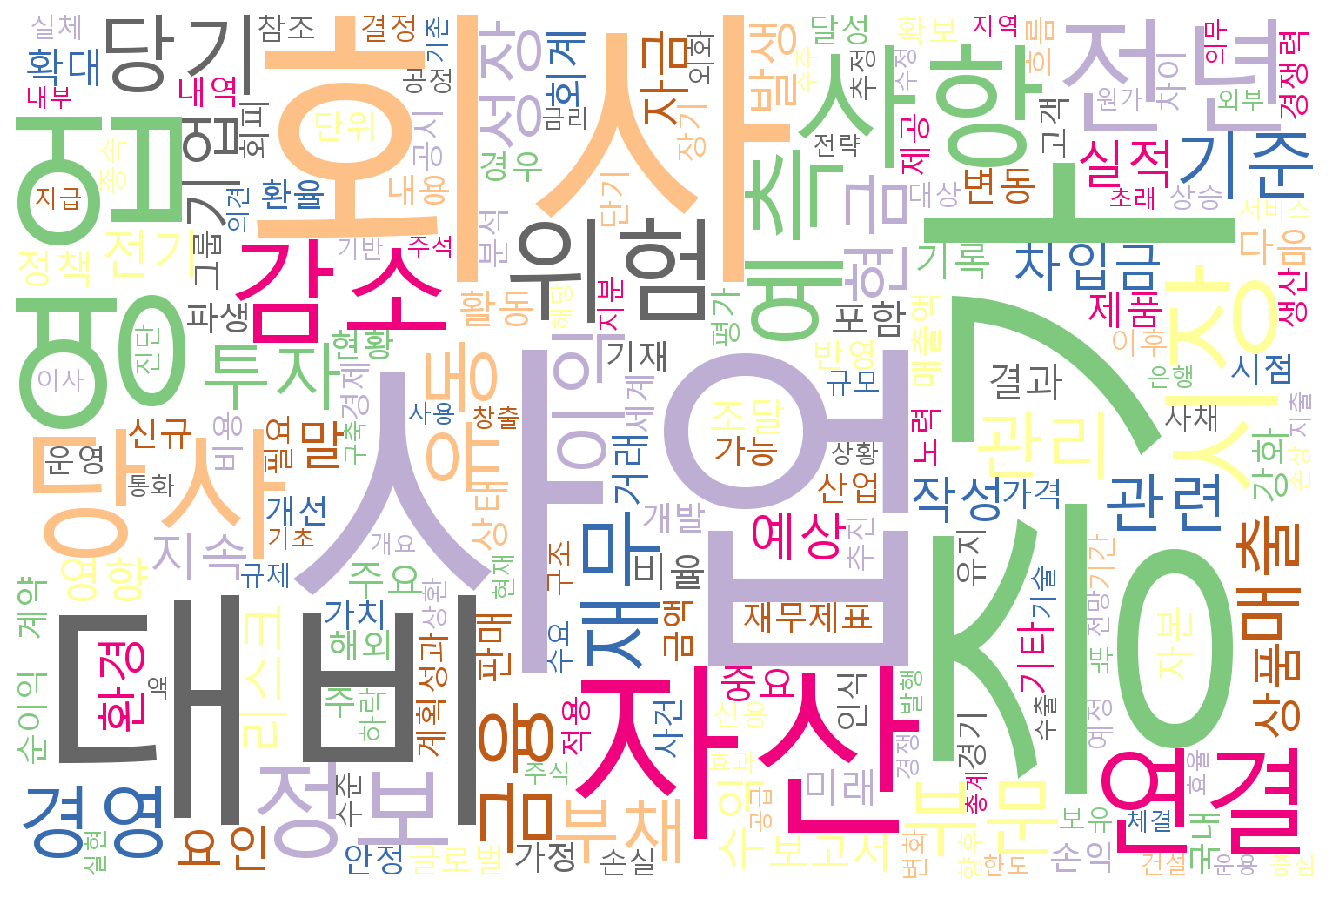

In [8]:
from wordcloud import WordCloud #wordcloud 생성
from IPython.display import set_matplotlib_formats
import matplotlib

matplotlib.rc('font',family = 'Malgun Gothic')
set_matplotlib_formats('retina')
matplotlib.rc('axes',unicode_minus = False)
plt.rcParams["figure.figsize"] = (15,8)
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "Accent_r",
            width=1500, height=1000).generate_from_frequencies(nouns_dic) #여기에 dic형태넣어주기

plt.imshow(wordcloud)
plt.axis('off')
plt.show;

## Document size check

In [9]:
print(df.shape)
print(tfd_tokens.shape)
print(tfd_nouns.shape)

(1117, 9)
(14198, 2)
(9865, 2)


dataset은 10년동안 kospi200에 계속 편입되어있던 113개의 기업의 발간 사업보고서들인 1117개의 Documents입니다.
Mecab으로 형태소분석을 했을 때 총 토큰들과 그 중 명사만 뽑아 term document freqeuncy를 빈도가 높은 순 대로 살펴보았는데 각각 14198, 9865개의 단어 수를 기록했습니다. 형태소분석 단어집합들은 숫자를 치환한 'num'와 조사가 빈도수가 가장 많았습니다.


다음으로는 조사와 num을 제외하여 단어 count를 살펴보고, tfd_nouns와 비교 후 이를 documnet filings 연도별로 매칭시켜 연도별 word counts의 frequency를 살펴보도록 하자.

In [10]:
df_count = df.copy()
df_count = df_count.loc[:,['연도','crp_nm','rpt_nm']]
word_count_ls = [len(word_count(x).items()) for x in df.str_tokens]
word_count_noun_ls = [len(word_count(x).items()) for x in df.str_nouns]
df_count['document_size'] = word_count_ls
df_count['document_noun_size'] = word_count_noun_ls

In [11]:
df_count.document_size.describe()

count    1117.000000
mean      533.700090
std       261.591933
min        26.000000
25%       372.000000
50%       479.000000
75%       629.000000
max      1939.000000
Name: document_size, dtype: float64

In [12]:
df_count = df_count.sort_values(by = '연도')
year_ls = [sum(df_count[df_count.연도 == x].document_size) for x in df_count.연도.unique()]
year_noun_ls = [sum(df_count[df_count.연도 == x].document_noun_size) for x in df_count.연도.unique()]
doc_size_by_year = pd.DataFrame(list(zip(df_count.연도.unique(),year_ls,year_noun_ls)),columns= ['year','document','noun'])
doc_size_by_year = doc_size_by_year.sort_values(by = 'year', ascending= True).reset_index(drop=True)

In [13]:
doc_size_by_year

,year,document,noun
0,2010,49508,33040
1,2011,50372,33795
2,2012,56123,38041
3,2013,57949,39411
4,2014,58837,40150
5,2015,61647,42472
6,2016,60458,41609
7,2017,61814,42627
8,2018,67358,46905
9,2019,72077,50436


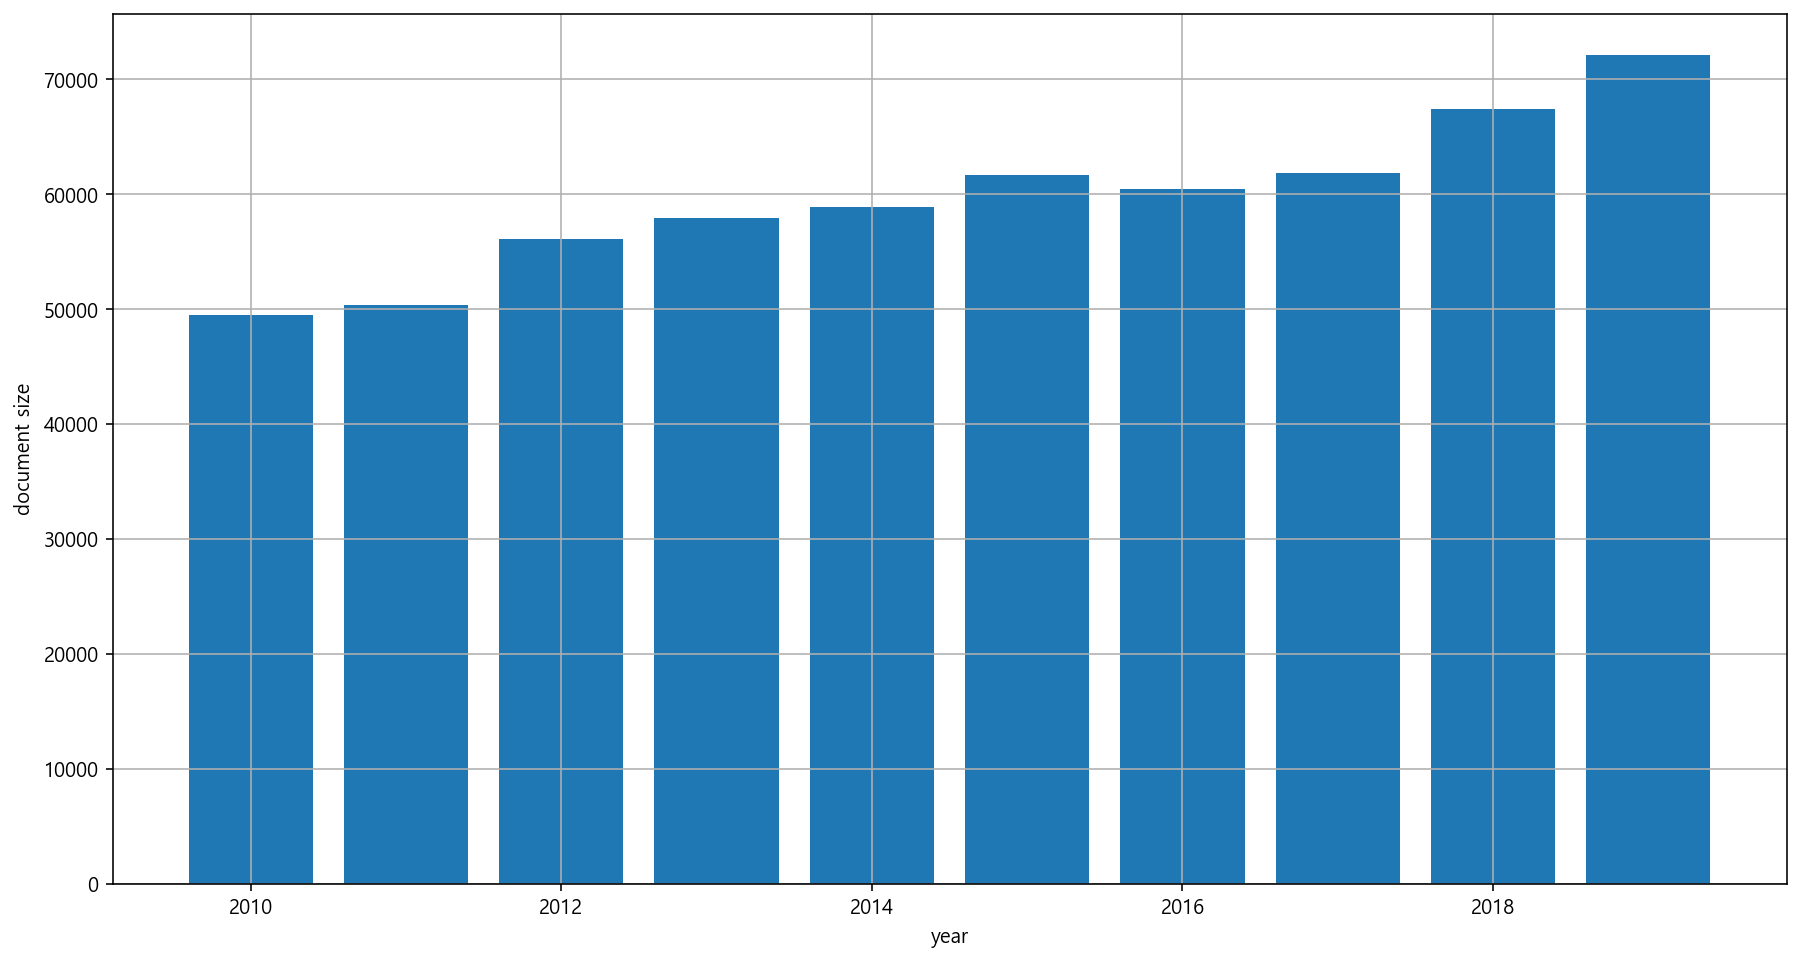

In [14]:
import matplotlib.pyplot as plt

plt.bar(doc_size_by_year.year, doc_size_by_year.document)

plt.xlabel('year')
plt.ylabel('document size')
plt.show()

Similarity_Cohen_Malloy_Nguyen(2019)Lazy Prices의 내용과 마찬가지로 미국 뿐만 아니라 한국에서도 10년간 사업보고서 내의 단어 빈도가 꾸준히 증가하였다. 토큰화된 사업보고서의 텍스트를 기준으로 하였으며 명사로 봤을 때도 단조 증가하는 양상은 동일하였다.

## Document Similarity

In [15]:
def length_adjust(str_) : 
    return (2-len(str_)) * '0' + str_

def date_convertor(date) : 
    year = length_adjust(str(date.year))
    month = length_adjust(str(date.month))
    day = length_adjust(str(date.day))
    yyyymmdd = int(year+month+day)
    return yyyymmdd

In [16]:
def cal_sim(df,type_):
    
    
    naive_df = df.copy()
    lv2_index = pd.date_range(start='20100101', end='20191231')
    lv2_index = list(map(date_convertor,lv2_index))
    lv2_columns = naive_df.crp_nm.unique()

    lv2_df = \
    pd.DataFrame(np.full(shape=(len(lv2_index),len(lv2_columns)),fill_value=np.nan),index=lv2_index,columns=lv2_columns)
    
    for process,corp_name in enumerate(lv2_columns):
        print("Process : {} | Total : {}".format(process+1,len(lv2_columns)),end='\r')

        tmp_df = naive_df[naive_df.crp_nm == corp_name]

        min_yr = tmp_df['연도'].min() #2010
        max_yr = tmp_df['연도'].max() #2019

        tmp_tf = tfidf.fit_transform(tmp_df.str_tokens) #vectorize as matrix
        tmp_cosine = linear_kernel(tmp_tf,tmp_tf)

        sim_ls = []; year_ls = []

        for yr in range(min_yr,max_yr) :

            pre_df = tmp_df[tmp_df['연도'] == yr]
            next_df = tmp_df[tmp_df['연도'] == yr+1]

            publish_date = tmp_df[tmp_df['연도'] == yr+1]['rcp_dt']

            if len(pre_df) == 0 or len(next_df) ==0:
                continue

            else:
                if type_ == 'cosine':
                    concat_df = pd.concat([pre_df,next_df]) 
                    co_vec = tfidf.fit_transform(concat_df.str_nouns)
                    sim = linear_kernel(co_vec)[1][0]
                    
                elif type_ == 'jaccard':
                    pre_token = pre_df.str_tokens.map(lambda x : x.split(" ")).values
                    next_token = next_df.str_tokens.map(lambda x : x.split(" ")).values   
                    if type(pre_token[0]) == list and type(next_token[0]) == list :
                        sim = len(set(next_token[0])&set(pre_token[0]))/len(set(next_token[0] + pre_token[0]))
                    else : 
                        sim = len(set(next_token)&set(pre_token))/len(set(next_token + pre_token))
                    

            year_ls.append(publish_date.values[0])
            sim_ls.append(sim)

            assert len(year_ls) == len(sim_ls)
            lv2_df.loc[year_ls,corp_name] = sim_ls
    
    return lv2_df

In [17]:
%%time
cosine_df = cal_sim(df,'cosine')
jaccard_df = cal_sim(df,'jaccard')

Wall time: 11.8 sotal : 113


In [18]:
jaccard_df.mean().mean()

0.6590837093668442

In [20]:
cosine_df.mean().mean()

0.8491577150668567

In [26]:
jaccard_df.corr()

,삼양홀딩스,유한양행,CJ대한통운,두산,대림산업,한국테크놀로지그룹,기아차,동아쏘시오홀딩스,SK하이닉스,영풍,...,현대백화점,한국금융지주,GS,하나금융지주,아모레퍼시픽,LF,후성,SK이노베이션,CJ제일제당,KB금융
삼양홀딩스,1.000000,-0.121265,0.510052,0.484805,-0.181615,0.456424,0.739389,0.470728,-0.196433,0.720685,...,-0.438534,0.611408,-0.227799,0.474572,-0.303812,-0.162112,0.638174,0.714383,0.177361,0.461765
유한양행,-0.121265,1.000000,-0.563007,0.674728,0.685744,-0.190072,-0.228506,-0.141284,-0.317269,0.029838,...,-0.648606,0.609356,0.096795,-0.400850,0.097821,0.351957,0.285928,0.205852,-0.228675,-0.527567
CJ대한통운,0.510052,-0.563007,1.000000,0.112602,-0.583837,-0.187240,0.392802,0.265106,-0.273770,0.680366,...,0.068240,0.168630,-0.502425,0.085731,-0.156486,0.308750,0.504512,0.531432,0.270728,0.524595
두산,0.484805,0.674728,0.112602,1.000000,-0.037343,-0.162081,0.584917,0.441171,-0.568134,0.828011,...,-0.186346,0.712756,-0.050675,-0.358632,-0.616615,0.465425,0.805621,0.750442,0.104626,0.317370
대림산업,-0.181615,0.685744,-0.583837,-0.037343,1.000000,-0.028141,-0.259802,-0.206362,0.165178,-0.393944,...,-0.203051,0.383220,-0.341506,-0.312366,0.258942,-0.134729,-0.533046,-0.352905,0.434506,-0.851716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LF,-0.162112,0.351957,0.308750,0.465425,-0.134729,-0.418897,-0.424888,-0.499568,-0.807528,0.254905,...,-0.678014,0.853684,-0.631153,-0.550537,-0.521005,1.000000,0.436337,0.191066,-0.313077,-0.059636
후성,0.638174,0.285928,0.504512,0.805621,-0.533046,0.257758,0.542936,0.574305,-0.650051,0.853427,...,-0.440992,0.490837,-0.349427,0.428376,-0.173121,0.436337,1.000000,0.885171,-0.388928,0.371650
SK이노베이션,0.714383,0.205852,0.531432,0.750442,-0.352905,0.048076,0.551845,0.815882,-0.337152,0.785786,...,-0.324672,0.249445,-0.118309,0.411458,-0.040790,0.191066,0.885171,1.000000,-0.075361,0.343434
CJ제일제당,0.177361,-0.228675,0.270728,0.104626,0.434506,-0.329834,0.234723,0.202992,0.630439,-0.095234,...,0.493388,-0.322924,0.028463,-0.196518,0.620146,-0.313077,-0.388928,-0.075361,1.000000,-0.039276
